# EfficientNet

In [1]:
import os
import cv2
import pydicom
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Load and Transform Data

In [2]:
train = pd.read_csv('D:/CSE499/osic-pulmonary-fibrosis-progression/train.csv')

In [3]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [4]:
train.SmokingStatus.unique()

array(['Ex-smoker', 'Never smoked', 'Currently smokes'], dtype=object)

In [5]:
def get_tab(df):
    "raturn an array which contains each patient normalized age, sex and smoking status"
    vector = [(df.Age.values[0] - 30) / 30] 
    
    if df.Sex.values[0].lower() == 'male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector)

In [6]:
A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(train.Patient.unique())): # i index, p patient id
    sub = train.loc[train.Patient == p, :] # find all data (weeks, FVC, Percent, Age, Sex, SmokingStatus) of a unique patient
    fvc = sub.FVC.values # fvc values of the patient during the follow-up
    weeks = sub.Weeks.values # follow-up weeks
    c = np.vstack([weeks, np.ones(len(weeks))]).T # create an array by the follow-up weeks of shape(len(weeks),2)
    a, b = np.linalg.lstsq(c, fvc)[0] # least-square sol, a=gradient matrix, b=right hand matrix 
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

C:\Users\Monir\anaconda3\envs\rabbi36\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


In [7]:
def get_img(path):
    "read DICOM dataset and return resize images of size (512,512,1)"
    d = pydicom.dcmread(path) # read and parse the CT scan images (in DICOM format)
    resized_image = cv2.resize((d.pixel_array - d.RescaleIntercept) / (d.RescaleSlope * 1000), (512,512))
    return resized_image

In [8]:
from tensorflow.keras.utils import Sequence

class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size):
        "key=patient, a=gradient matrix, tab=a particular patient's data"
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'D:/CSE499/osic-pulmonary-fibrosis-progression/train/{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size) # randomly chooses n=batch_size number of patients
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0] # chooses some randomly images for kth patient
                img = get_img(f'D:/CSE499/osic-pulmonary-fibrosis-progression/train/{k}/{i}') # resizes ith image of kth patient
                x.append(img) # append kth patient's image data in the list x
                a.append(self.a[k]) # append kth patient's gradinet in the list a
                tab.append(self.tab[k]) # append kth patient's tabular data in the tab list
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab) # convert list to array
        x = np.expand_dims(x, axis=-1) 
        return [x, tab] , a

## Build the Model

In [9]:
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, GaussianNoise, 
    Add, Conv2D, AveragePooling2D, LeakyReLU, Concatenate 
)

In [10]:
import efficientnet.tfkeras as efn

def get_efficientnet(model, shape):
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False),
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(512, 512, 1), model_class=None):
    inp = Input(shape=shape)
    base = get_efficientnet(model_class, shape)
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    inp2 = Input(shape=(4,)) # indicates that the expected input will be batches of 4-dimensional vectors
    x2 = GaussianNoise(0.2)(inp2) # to mitigate overfitting
    x = Concatenate()([x, x2]) 
    x = Dropout(0.5)(x) 
    x = Dense(1)(x)
    model = Model([inp, inp2] , x)
    return model

In [11]:
MODEL_CLASS = 'b3'
base_model = build_model(shape=(512, 512, 1), model_class=MODEL_CLASS)
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
efficientnet-b3 (Model)         (None, 16, 16, 1536) 10782808    input_1[0][0]                    
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1536)         0           efficientnet-b3[1][0]            
______________________________________________________________________________________________

## Compile and Train the Model

In [12]:
BATCH_SIZE = 1
EPOCHS = 80
LR = 0.001
SAVE_BEST = True

In [13]:
P = np.array(P)
subs = []
folds_history = []

"""
er = tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=1e-3,patience=15,verbose=1,mode="auto",baseline=None,
      restore_best_weights=True,) #Stop training when a monitored metric has stopped improving.
"""

cpt = tf.keras.callbacks.ModelCheckpoint(filepath=f'C:/Users/Monir/Documents/CSE499/models/EfficientNet/{MODEL_CLASS}_{EPOCHS}_epochs.h5',monitor='val_loss',verbose=1, 
    save_best_only=SAVE_BEST,mode='auto') #to save model or weights in a checkpoint file at lowest validation loss

rlp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5, verbose=1, min_lr=1e-8) 
     #Reduce learning rate when a metric has stopped improving.
     # if improvement stops, after 5 epochs learning rate will be reduced

model = build_model(model_class=MODEL_CLASS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mae") 
history = model.fit(IGenerator(keys=P, a = A, tab = TAB, batch_size=BATCH_SIZE), 
                    steps_per_epoch = 32,
                    validation_data=IGenerator(keys=P, a = A, tab = TAB, batch_size=BATCH_SIZE),
                    validation_steps = 32, 
                    callbacks = [cpt, rlp], 
                    epochs=EPOCHS)
folds_history.append(history.history)
print('Training Complete!!!')

Epoch 1/80
32/32 [==============================] - ETA: 0s - loss: 4.2292
Epoch 00001: val_loss improved from inf to 5.37834, saving model to C:/Users/Monir/Documents/CSE499/models/EfficientNet/b3_80_epochs.h5
32/32 [==============================] - 7s 213ms/step - loss: 4.2292 - val_loss: 5.3783 - lr: 0.0010
Epoch 2/80
32/32 [==============================] - ETA: 0s - loss: 4.7296
Epoch 00002: val_loss did not improve from 5.37834
32/32 [==============================] - 4s 125ms/step - loss: 4.7296 - val_loss: 45.0640 - lr: 0.0010
Epoch 3/80
32/32 [==============================] - ETA: 0s - loss: 4.4871
Epoch 00003: val_loss did not improve from 5.37834
32/32 [==============================] - 4s 124ms/step - loss: 4.4871 - val_loss: 9.7447 - lr: 0.0010
Epoch 4/80
32/32 [==============================] - ETA: 0s - loss: 3.5379
Epoch 00004: val_loss did not improve from 5.37834
32/32 [==============================] - 4s 126ms/step - loss: 3.5379 - val_loss: 22.0143 - lr: 0.0010
E

Epoch 34/80
32/32 [==============================] - ETA: 0s - loss: 3.3537
Epoch 00034: val_loss did not improve from 5.37834
32/32 [==============================] - 4s 121ms/step - loss: 3.3537 - val_loss: 85.1981 - lr: 1.5625e-05
Epoch 35/80
32/32 [==============================] - ETA: 0s - loss: 4.3252- ETA: 1s
Epoch 00035: val_loss did not improve from 5.37834
32/32 [==============================] - 4s 125ms/step - loss: 4.3252 - val_loss: 132.5123 - lr: 1.5625e-05
Epoch 36/80
32/32 [==============================] - ETA: 0s - loss: 4.5387
Epoch 00036: val_loss did not improve from 5.37834

Epoch 00036: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
32/32 [==============================] - 4s 126ms/step - loss: 4.5387 - val_loss: 136.2996 - lr: 1.5625e-05
Epoch 37/80
32/32 [==============================] - ETA: 0s - loss: 3.5357
Epoch 00037: val_loss did not improve from 5.37834
32/32 [==============================] - 4s 127ms/step - loss: 3.5357 - val_los

Epoch 67/80
32/32 [==============================] - ETA: 0s - loss: 4.3249
Epoch 00067: val_loss did not improve from 5.37834
32/32 [==============================] - 4s 120ms/step - loss: 4.3249 - val_loss: 115.8597 - lr: 1.2207e-07
Epoch 68/80
32/32 [==============================] - ETA: 0s - loss: 3.8877
Epoch 00068: val_loss did not improve from 5.37834
32/32 [==============================] - 4s 124ms/step - loss: 3.8877 - val_loss: 138.8895 - lr: 1.2207e-07
Epoch 69/80
32/32 [==============================] - ETA: 0s - loss: 4.6059
Epoch 00069: val_loss did not improve from 5.37834
32/32 [==============================] - 4s 125ms/step - loss: 4.6059 - val_loss: 71.2980 - lr: 1.2207e-07
Epoch 70/80
32/32 [==============================] - ETA: 0s - loss: 3.5848
Epoch 00070: val_loss did not improve from 5.37834
32/32 [==============================] - 4s 119ms/step - loss: 3.5848 - val_loss: 130.6610 - lr: 1.2207e-07
Epoch 71/80
32/32 [==============================] - ETA: 0s 

# Save Model History 

In [14]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'EffNet_b3_80_epoch_history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'EffNet_b3_80_epoch_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Visualize Training Results

In [15]:
result_dir = 'C:/Users/Monir/Documents/CSE499/results_and_figures/EfficientNet/B3/'

import tikzplotlib
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS) 

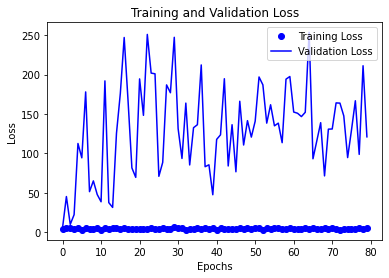

In [16]:
plt.plot(epochs_range, loss, 'bo', label='Training Loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.savefig(result_dir + 'b3_80_epoch_oss.png')
plt.savefig(result_dir + 'b3_80_epoch_loss.pdf', dpi=150)
tikzplotlib.save(result_dir + 'b3_80_epoch_loss.tex')

plt.show()

In [19]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

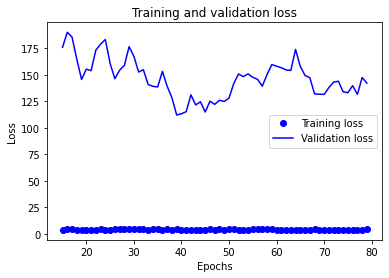

In [20]:
epochs_range = range(15,EPOCHS) 
plt.plot(epochs_range,smooth_curve(loss[15:]), 'bo', label='Training loss')
plt.plot(epochs_range,smooth_curve(val_loss[15:]), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.savefig(result_dir + 'b3_80_epoch_loss_smooth.png')
plt.savefig(result_dir + 'b3_80_epoch_smooth.pdf', dpi=150)
tikzplotlib.save(result_dir + 'b3_80_epoch_smooth.tex')

plt.show()